# Introduction

## Notebook preparation

In [534]:
import warnings

warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from urllib.request import urlopen
import json
import plotly.express as px
import plotly.io as pio
import kaleido


from matplotlib.ticker import PercentFormatter
plt.rcParams.update({ "figure.figsize" : (8, 5),"axes.facecolor" : "white", "axes.edgecolor":  "black"})
plt.rcParams["figure.facecolor"]= "w"
pd.plotting.register_matplotlib_converters()
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# set palette
# custom_palette = ['#1f78b', '#33a02c', '#e31a1c', '#ff7f00', '#6a3d9a']

sns.set_palette("flare")
colors = sns.color_palette("flare")
colors_cont = sns.color_palette("flare", as_cmap=True)

plt.rcParams['axes.prop_cycle'] = plt.cycler(color=colors)


## Task
1. Through EDA/statistical analysis above please come up with **AT LEAST 3 insights regarding the overall data**. One should be geographical.
1. In addition also come up with **AT LEAST 3 recommendations** for your client. 

### Client
- name: William Rodriguez	
- type: Buyer	
- household: 2 people, 
- needs: 
    - country house (best timing & non-renovated)
    - city house (fast & central location)

### Overall questions and insights
- average sizes, numbers of rooms etc
- average price, cyclicality of prices
- correlation: size and no rooms
- (geo)

### Client specific questions and insights
- country house: 
    - cyclicality of prices for the specific subgroup
    - non-renovated: price vs renovated for same number of rooms
    - price by lot size vs price by house size vs price by room number

- city house: location analysis based on zipcode
    - correlation size vs price 
    - correlation size vs room size 

# Data load and clean

In [303]:
# import data
df = pd.read_csv('data/eda.csv')

# df.head()
# df.columns

## Initial data inspection
- **shape**: 21,597 observations of 22 variables
- **variable names**: all variable names are Pythonic
- **variable types**: all variable types are appropriate apart from date: it is an `object`, when it should be `datetype64`
- **variable encoding**: fix year built by dividing by 10

We have invormation about: 
- price,
- location and size of plot,
- number of floors,
- number, size and type of rooms, 
- dates of construction, last renovation and condition. 


(Interesting find: for `int` type does not support missing values, so Python default chooses type `float`. If I try turning it into `int` I get the error `IntCastingNaNError`, which in Pythonic


In [ ]:
## DATA SHAPE & VARNAMES

print(df.shape)
print("\n")
print(df.columns)


# notes: 
    # seems that variable names are okay (all "Pythonic")

In [ ]:
## INSPECTION OF VARIABLE VALUES
df.describe()

# even categorical variables are in numeric form, yay! 
# Year renovated is a mess though. Fix in next cell.

In [304]:
## FIX YEAR RENOVATED
# year renovated has an extra 0 at the end. Divide by 10 to fix.
df['yr_renovated'] = df.yr_renovated.apply(lambda x: x/10)
df.loc[df.yr_renovated != 0].yr_renovated.describe()

## FIX ZIPCODE
df['zipcode'] = df.zipcode.astype('str')

In [306]:
## DATA TYPES

# print(df.dtypes)

df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
# df.head()

# problematic types
    # date is an object --> turn into date using datetime()
    # waterfront, view, yr_renovated --> turn into int

# df = df.astype({'yr_renovated': int})
# !!interesting find!!: int cannot be NA --> python automatically chose float for int value variables


## Deal with missing values
- sales information has no missing values, only some house characteristics are missing --> perform analysis of missing values on a set of unique houses only (21,420 houses)


- missing values for 4 variables: 
    - `waterfront`: 2360 missings (11.02%)
    - `view`: 63 missings (0.29%)
    - `sqft_basement`: 451 missings (2.11%)
    - `yr_renovated`: 3811 missings (17.79%)



- the missing values are not correlated: there is no systematic relationship among missing values

- I deal with missing values by imputing 0s. This means: 
    - `waterfront`: assume house is not on waterfront
    - `view`: assume house is without a view
    - `sqft_basement`: assume house has no basement
    - `yr_renovated`: assume house was not renovated

In [307]:
## inspect missing values
df.isna().sum() #
houses = df.drop(['sale_id', 'date', 'price'], axis = 1).drop_duplicates()
# houses.isna().sum()

# print shares of missing values
for key, value in dict(houses.isna().sum()).items(): 
    if value != 0:
        print(f"- `{key}`: {value} missings ({round(value/len(houses)*100, 2)}%)")
    # houses.waterfront.isna().sum()/len(houses)*100

- `waterfront`: 2360 missings (11.02%)
- `view`: 63 missings (0.29%)
- `sqft_basement`: 451 missings (2.11%)
- `yr_renovated`: 3811 missings (17.79%)


In [535]:
## show heatmap for correlation among missing values
#  msno.heatmap(houses)
# very little correlation among missing variables: no systematic issues

In [308]:
## fill missing values with 0s
df = df.fillna(0)

# df.isna().sum() --> no missing values anymore, yay!

## Add features

### Additional data load
- from https://simplemaps.com/data/us-zips retrieve demographic informaiton about zipcoded
- the relevant information is: 
    - population density: to identify 'country' zipcodes
    - city of zipcode: to identiy 'central' zipcodes

#### US zips

In [ ]:
# load US zips data
king_zips = pd.read_csv('data/uszips.csv', dtype= str)
king_zips.head()

# keep only relevant data: King county and 3 variables of interest 
king_zips = pd.DataFrame(king_zips).loc[king_zips.county_fips == "53033", ['zip', 'density', 'city']]

# clean density column
king_zips['density'] = king_zips.density.astype('float')

# rename zipcode to match format of the other dataset
king_zips = king_zips.rename(columns = {'zip': 'zipcode'})
king_zips.head()

# king_zips.describe()
# king_zips.shape

In [350]:
## merge King county demographic inforamtion

# df = pd.merge(df, king_zips, how = 'left', on = 'zipcode')
# df.head()

#### GeoJSON for zip code coordinates

In [ ]:
## load GeoJSON data for zipcodes

with urlopen('https://raw.githubusercontent.com/OpenDataDE/State-zip-code-GeoJSON/master/wa_washington_zip_codes_geo.min.json') as response:
    zipcodes = json.load(response)

price_by_zipcode = df.groupby('zipcode').agg({'price': 'mean', 'price_sqft': 'mean'}).reset_index()
# price_by_zipcode['zipcode'] = df.zipcode.astype('str')
price_by_zipcode.head()

### Add additional variables

In [313]:
# Create variables that idenitfy the zipcode type

df['zip_country'] = df.density.apply(lambda x: 1 if x < 500 else 0)
df['zip_city'] = df.city.apply(lambda x: 1 if x == 'Seattle' else 0)
df['zip_type'] = df.apply(lambda x: 'city' if x.zip_city == 1 else ('country' if x.zip_country == 1 else 'suburbs'), axis = 1)

df.head()

,sale_id,date,price,id,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,...,zipcode,lat,long,sqft_living15,sqft_lot15,density,city,zip_country,zip_city,zip_type
0,1,2014-10-13,221900.000,7129300520,3.000,1.000,1180.000,5650.000,1.000,0.000,...,98178,47.511,-122.257,1340.000,5650.000,2070.400,Seattle,0,1,city
1,2,2014-12-09,538000.000,6414100192,3.000,2.250,2570.000,7242.000,2.000,0.000,...,98125,47.721,-122.319,1690.000,7639.000,3087.700,Seattle,0,1,city
2,3,2015-02-25,180000.000,5631500400,2.000,1.000,770.000,10000.000,1.000,0.000,...,98028,47.738,-122.233,2720.000,8062.000,1479.500,Kenmore,0,0,suburbs
3,4,2014-12-09,604000.000,2487200875,4.000,3.000,1960.000,5000.000,1.000,0.000,...,98136,47.521,-122.393,1360.000,5000.000,2901.700,Seattle,0,1,city
4,5,2015-02-18,510000.000,1954400510,3.000,2.000,1680.000,8080.000,1.000,0.000,...,98074,47.617,-122.045,1800.000,7503.000,1118.000,Sammamish,0,0,suburbs


In [351]:
# Generate time variables

df['month'] = df.date.dt.month
df['year'] = df.date.dt.year
df['year_month'] = df.date.dt.strftime('%Y-%m')

In [352]:
# Generate price per square foot
df['price_sqft'] = df['price']/df['sqft_living']

In [419]:
# Generate land to house ratio
df['land_to_house'] = df.sqft_lot / df.sqft_living

In [353]:
# Final peak at data before analysis
df.head()

,sale_id,date,price,id,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,...,density,city,zip_country,zip_city,zip_type,month,year,year_month,price_sqft,land_to_house
0,1,2014-10-13,221900.000,7129300520,3.000,1.000,1180.000,5650.000,1.000,0.000,...,2070.400,Seattle,0,1,city,10,2014,2014-10,188.051,4.788
1,2,2014-12-09,538000.000,6414100192,3.000,2.250,2570.000,7242.000,2.000,0.000,...,3087.700,Seattle,0,1,city,12,2014,2014-12,209.339,2.818
2,3,2015-02-25,180000.000,5631500400,2.000,1.000,770.000,10000.000,1.000,0.000,...,1479.500,Kenmore,0,0,suburbs,2,2015,2015-02,233.766,12.987
3,4,2014-12-09,604000.000,2487200875,4.000,3.000,1960.000,5000.000,1.000,0.000,...,2901.700,Seattle,0,1,city,12,2014,2014-12,308.163,2.551
4,5,2015-02-18,510000.000,1954400510,3.000,2.000,1680.000,8080.000,1.000,0.000,...,1118.000,Sammamish,0,0,suburbs,2,2015,2015-02,303.571,4.810


# Analysis

## General insights about the data

### General insight 1: overview of dataset
- There is a great variety of properties being sold and bought
- Majority of the houses: 
    - cost below 500k
    - are below 2000sqft (185sqm)
    - have a lot size of < 7500 sqft (700sqm)
    - have 3 or fewer bedrooms

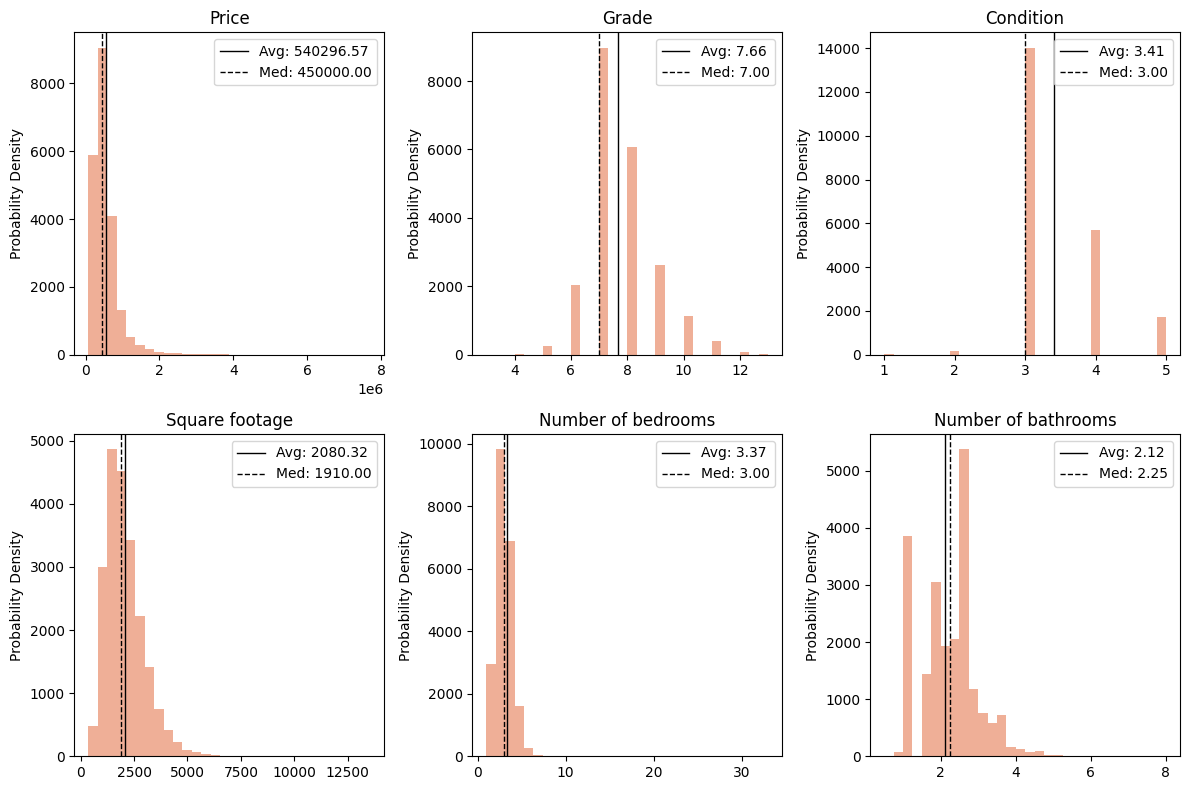

In [385]:
# histograms of variables of interest
cols = ['price', 'grade', 'condition', 'sqft_living', 'bedrooms', 'bathrooms']
titles = ['Price', 'Grade', 'Condition', 'Square footage', 'Number of bedrooms', 'Number of bathrooms']


fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))
axes = axes.flatten()

# Plot normalized histograms for each variable
for i, var in list(zip(range(len(cols)+1), cols)) :
    
    # plot histogram
    axes[i].hist(df[var], bins=30, alpha=0.7)

    # label plot and axes
    axes[i].set_title(f'{titles[i]}')
    axes[i].set_xlabel('')
    axes[i].set_ylabel('Probability Density')

    # add mean and median
    mean_value = np.mean(df[var])
    median_value = np.median(df[var])
    axes[i].axvline(mean_value, color='black', linestyle='solid', linewidth=1, label=f'Avg: {mean_value:.2f}')
    axes[i].axvline(median_value, color='black', linestyle='dashed', linewidth=1, label=f'Med: {median_value:.2f}')

    # add legend 
    axes[i].legend()

# adjust layout
plt.tight_layout()

# save the figure
plt.savefig('graphs/general_1_histograms.png')

# display the plot
plt.show()


### General insight 2: price cyclicality 

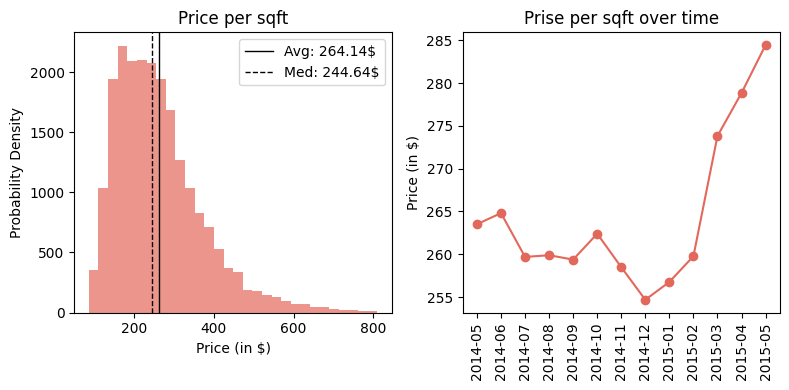

In [506]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))

axes = axes.flatten()

# plot 1: plot histogram of price_sqft
axes[0].hist(df['price_sqft'], bins=30, alpha=0.7, color = colors[1])
axes[0].set_title(f'Price per sqft')
axes[0].set_xlabel('Price (in $)')
axes[0].set_ylabel('Probability Density')

# calculate mean and median
mean_value = np.mean(df['price_sqft'])
median_value = np.median(df['price_sqft'])

# add mean and median to plot
axes[0].axvline(mean_value, color='black', linestyle='solid', linewidth=1, label=f'Avg: {mean_value:.2f}$')
axes[0].axvline(median_value, color='black', linestyle='dashed', linewidth=1, label=f'Med: {median_value:.2f}$')
axes[0].legend()

#-----------------------

# plot 2: plot price per square foot over time

plt.plot(price_sqft_month.year_month, price_sqft_month.price_sqft, marker = 'o', color = colors[1])
axes[1].set_title('Prise per sqft over time')
axes[1].set_xlabel('')
axes[1].set_ylabel('Price (in $)')
plt.xticks(rotation = 90)

# adjust layout
plt.tight_layout()

# save plot
plt.savefig('graphs/general_2_price_sqft.png')

# display the plot
plt.show()

### General insight 3: geographical analysis of price per sqft

In [ ]:
# map: sqft price per zip code
fig = px.choropleth_mapbox(price_by_zipcode, geojson=zipcodes, locations='zipcode', color='price_sqft',
                           color_continuous_scale=[[0, colors.as_hex()[1]], [0.5, 'ivory'], [1, colors.as_hex()[-1]]],
                           zoom=8.3, center = {"lat": 47.433422, "lon": -122.090672}, 
                           range_color=(price_by_zipcode.price_sqft.min(), price_by_zipcode.price_sqft.max()),
                           mapbox_style="carto-positron",
                           featureidkey="properties.ZCTA5CE10",
                           opacity=0.5,
                           labels={'price':'average house price'}
                          )
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

pio.write_image(fig, 'graphs/general_3_price_zipcode.png', width=800, height=800)

## Specific insights for client nedds

### Specific insight 1: defining city and country houses

In [420]:
# Generate dataset: land to house ratio by zipcode

size_by_zipcode = df.groupby('zipcode').agg({'land_to_house': 'mean'}).reset_index()
# size_by_zipcode.head()

In [ ]:
# Map: land-to-house ratio by zipcode

fig = px.choropleth_mapbox(size_by_zipcode, geojson=zipcodes, locations='zipcode', color='land_to_house',
                           color_continuous_scale=[[0, colors.as_hex()[1]], [0.5, 'ivory'], [1, colors.as_hex()[-1]]],
                           zoom=8.3, center = {"lat": 47.433422, "lon": -122.090672}, 
                           range_color=(np.percentile(size_by_zipcode.land_to_house, 20), np.percentile(size_by_zipcode.land_to_house, 80)),
                           mapbox_style="carto-positron",
                           featureidkey="properties.ZCTA5CE10",
                           opacity=0.5,
                           labels={'land_to_house':'land-to-house ratio'}
                          )
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

pio.write_image(fig, 'graphs/specific_1_land_to_house.png', width=800, height=800)

In [ ]:
# Map: density by zipcode
fig = px.choropleth_mapbox(king_zips, geojson=zipcodes, locations='zipcode', color='density',
                           color_continuous_scale=[[0, colors.as_hex()[1]], [0.5, 'ivory'], [1, colors.as_hex()[-1]]],
                           zoom=8.3, center = {"lat": 47.433422, "lon": -122.090672}, 
                           range_color=(king_zips.density.min(),5000),
                           mapbox_style="carto-positron",
                           featureidkey="properties.ZCTA5CE10",
                           opacity=0.5, 
                           labels={'density':'population density'}
                          )
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

pio.write_image(fig, 'graphs/specific_1_density.png', width=800, height=800)

In [444]:
# Create categorical dataset which shows each zipcode's defined type
type_by_zipcode = df[['zipcode', 'zip_type']].drop_duplicates().reset_index(drop = True)
# type_by_zipcode


In [ ]:
# Map: type of each zipcode in dataset
fig = px.choropleth_mapbox(type_by_zipcode, geojson=zipcodes, color="zip_type",
                           locations="zipcode", featureidkey="properties.ZCTA5CE10",
                           zoom=8.3, center = {"lat": 47.433422, "lon": -122.090672}, 
                           color_discrete_sequence=[colors.as_hex()[1], "papayawhip", colors.as_hex()[5]],
                           mapbox_style="carto-positron", 
                           opacity = 0.5, 
                           labels={'zip_type':'type of zipcode'})

fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

pio.write_image(fig, 'graphs/specific_1_zipcode_type.png', width=800, height=800)

### Specific insight 2: Analysis of prices and qualities of country houses

In [445]:
# Summary of houses in the country

print(f"There are {df.loc[(df.zip_country == 1)].sale_id.count()} being sold in the country, {round(df.loc[(df.zip_country == 1)].sale_id.count()/len(df)*100, 2)}%")

country = df.loc[(df.zip_country == 1) & (df.land_to_house >= 5)]
print(f"Of the houses in the country, {len(country)} ({round(len(country)/df.loc[(df.zip_country == 1)].sale_id.count(), 2)*100}%) have the minimum land-to-house ratio.")

country['renovated'] = country.yr_renovated.apply(lambda x: "yes" if x != 0 else "no")
print(f"Of those houses, {len(country.loc[country.renovated == 'no'])} are not renovated.")

country = country.loc[country.renovated == 'no']

There are 3325 being sold in the country, 15.4%
Of the houses in the country, 1773 (53.0%) have the minimum land-to-house ratio.
Of those houses, 1716 are not renovated.


In [446]:
# Genearte aggreaged charts for price by month and price and quality by zipcode

country_price_month = country.groupby(['year','month', 'year_month']).price_sqft.mean().reset_index() 
# country_price_month.head()

country_price_zipcode = country.groupby(['zipcode']).agg({'price_sqft': 'mean', 'grade': 'mean'}).reset_index().sort_values(by = ['price_sqft'], ascending = 0)
# country_price_zipcode.head()


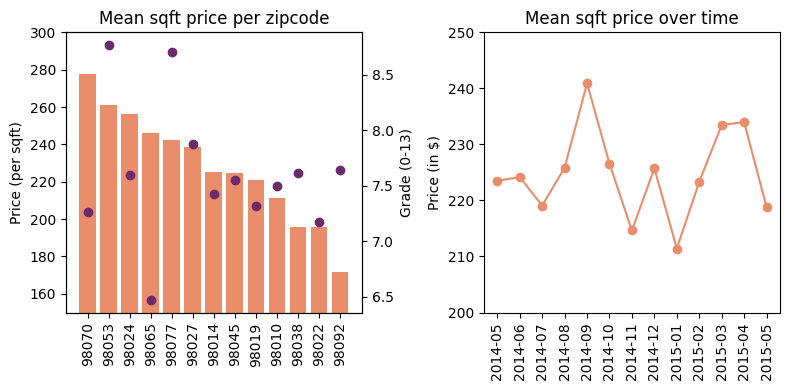

In [507]:
# Plot statistics of country houses (price per sqft by zipcode, price)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))

axes = axes.flatten()

#----------------------
# plot 1: price and grade by zipcode
axes[0].bar(country_price_zipcode.zipcode, country_price_zipcode['price_sqft'])

# label things
axes[0].set_title('Mean sqft price per zipcode')
axes[0].set_ylabel('Price (per sqft)')
axes[0].set_xlabel('')

# make axes nice
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=90)
axes[0].set_ylim(150,300)
plt.xticks(rotation = 90)

# secondary y-axis for the first subplot
axes2_0 = axes[0].twinx()
axes2_0.scatter(country_price_zipcode.zipcode, country_price_zipcode.grade, color=colors[5], label='')
axes2_0.set_ylabel('Grade (0-13)')
axes2_0.tick_params(axis='y')

#-----------------------
# plot 2: line chart of prices over time 
axes[1].plot(country_price_month.year_month, country_price_month.price_sqft, marker = 'o')

# label things
axes[1].set_title('Mean sqft price over time')
axes[1].set_xlabel('')
axes[1].set_ylabel('Price (in $)')

# make axes nice
axes[1].set_ylim(200,250)
plt.xticks(rotation = 90)

#-----------------------
# Adjust layout
plt.tight_layout()

plt.savefig('graphs/specific_2_country_analysis.png')
# Display the plot
plt.show()

### Specific insight 3: Recommendations for city house
    

In [456]:
# get an overview of city data
city = df.loc[(df.city == 'Seattle')]
city.shape

print(f'There were {city.shape[0]} houses sold in Seattle city ({round(city.shape[0]/len(df)*100, 2)}% of all houses).')
print(f'This includes {city.zipcode.nunique()} zipcodes in the King County.')

city = city.loc[(city.bedrooms <= 5)]

print(f'Out of those {city.shape[0]} were houses with 5 or fewer bedrooms.')


There were 8973 houses sold in Seattle city (41.55% of all houses).
This includes 29 zipcodes in the King County.
Out of those 8799 were houses with 5 or fewer bedrooms.


In [ ]:
# prepare dataset for map - monthly sales by zipcode

by_zipcode = city.groupby(['zipcode', 'year_month']).agg({'sale_id': 'count'}).reset_index().rename(columns= {'sale_id': 'sales_month'})
by_zipcode = by_zipcode.groupby('zipcode').agg({'sales_month': 'mean'}).reset_index()
by_zipcode.head()

In [ ]:
# map: city zipcodes by velocity

fig = px.choropleth_mapbox(by_zipcode, geojson=zipcodes, locations='zipcode', color='sales_month',
                           color_continuous_scale=[[0, colors.as_hex()[1]], [0.5, 'ivory'], [1, colors.as_hex()[-1]]],
                           range_color=(by_zipcode.sales_month.min(),by_zipcode.sales_month.max()),
                           mapbox_style="carto-positron",
                           zoom=9.5, center = {"lat": 47.5528, "lon": -122.335212}, 
                           featureidkey="properties.ZCTA5CE10",
                           opacity=0.5,
                           labels={'sales_month':'sales per month'}
                          )
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.update_layout(height=800, width=800)
fig.show()

pio.write_image(fig, 'graphs/specific_3_sales_velocity.png', width=800, height=800)

In [516]:
# prepare data for city analysis

# count of sales by number of bedrooms
by_bedrooms = city.groupby('bedrooms').agg({'sale_id': 'count'}).reset_index().rename(columns= {'sale_id': 'count_sales'})
by_bedrooms.head()

# data of high velocity zips to be shoved into a boxplot
velocity_zips = list(by_zipcode.loc[by_zipcode.sales_month > 30].zipcode)

high_velocity = city[(city.zipcode.isin(velocity_zips)) & (city.bedrooms.isin(range(1, 5)))]
high_velocity['price_mil'] = high_velocity.price/ 1000000

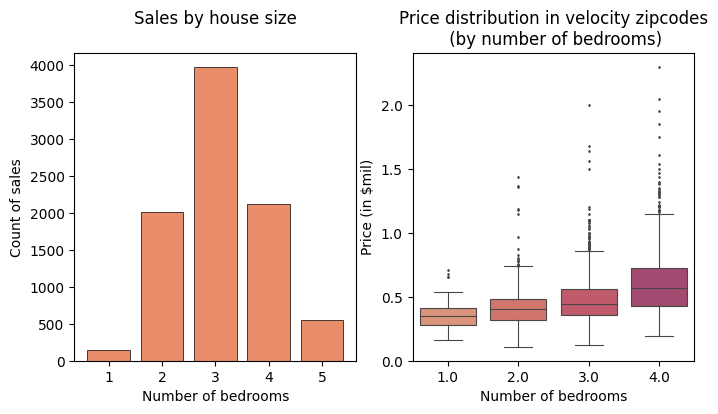

In [533]:
# plot city analysis

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))

# plot 1: count of sales by number of bedrooms
axes[0].bar(by_bedrooms['bedrooms'], by_bedrooms['count_sales'], edgecolor='black', linewidth = 0.5)
axes[0].set_xlabel('Number of bedrooms')
axes[0].set_ylabel('Count of sales')
axes[0].set_title('Sales by house size\n')

# plot 2: price distributions in high velocity neighborhoods by bedroom count
sns.boxplot(x = 'bedrooms', y = 'price_mil', data = high_velocity, ax = axes[1], 
            boxprops=dict(linewidth=0.8), 
            whiskerprops=dict(linewidth=0.8), 
            capprops=dict(linewidth=0.8), 
            flierprops=dict(linewidth=0.8, markersize = 1), 
            medianprops=dict(linewidth=0.8))
plt.xlabel('Number of bedrooms')
plt.ylabel('Price (in $mil)')
plt.title('Price distribution in velocity zipcodes\n (by number of bedrooms)', fontsize = 12)

# plt.savefig('graphs/specific_3_price_bedrooms.png')
plt.savefig('graphs/specific_3_city_analysis.png')